In [1]:
# Imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Subset
import copy
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Dataset paths
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

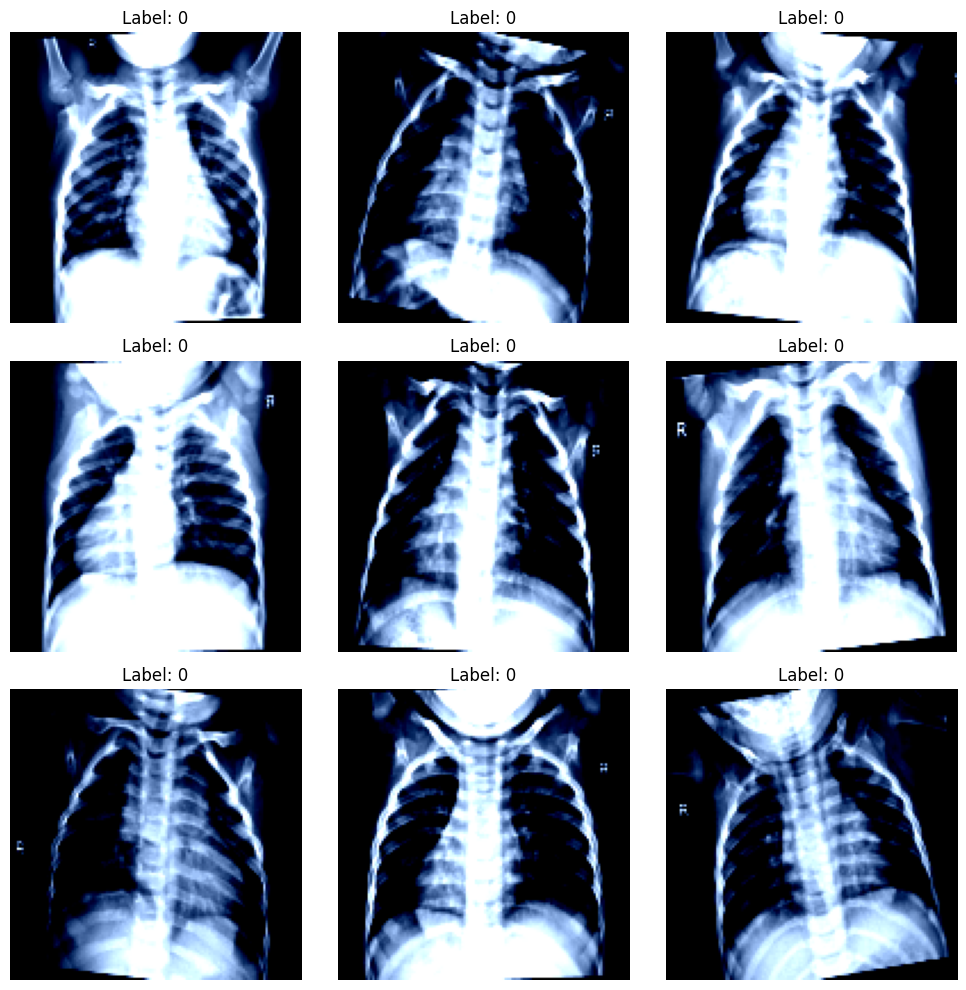

In [3]:
# Display a few sample images from the dataset
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        image, label = dataset[i]
        plt.imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC format
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function with the training dataset
visualize_images(train_dataset)

In [9]:
# Client A: Image feature extractor
class ClientModel(nn.Module):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        # Remove final layer for feature extraction
        self.model.classifier = nn.Identity()  
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
client_a = ClientModel().to(device)
client_b = ClientModel().to(device)

In [13]:
class Aggregator(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(Aggregator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

# Combine features from both clients
aggregator = Aggregator(input_dim=1280 + 1280).to(device)  

In [17]:
from tqdm import tqdm

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_a = optim.Adam(client_a.parameters(), lr=0.001)
optimizer_b = optim.Adam(client_b.parameters(), lr=0.001)
optimizer_agg = optim.Adam(aggregator.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    client_a.train()
    client_b.train()
    aggregator.train()
    
    epoch_loss = 0
    for images, labels in tqdm(train_loader, desc=f"{epoch+1}/{epochs}"):
        # Split images and metadata (simulated)
        batch_size = images.size(0)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Forward pass on clients
        features_a = client_a(images.to(device)) 
        features_b = client_b(images.to(device)) 
        
        # Concatenate features and pass to aggregator
        combined_features = torch.cat((features_a, features_b), dim=1)
        outputs = aggregator(combined_features)
        
        # Loss computation
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        
        # Backward pass
        optimizer_a.zero_grad()
        optimizer_b.zero_grad()
        optimizer_agg.zero_grad()
        loss.backward()
        
        optimizer_a.step()
        optimizer_b.step()
        optimizer_agg.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

1/10: 100%|██████████| 163/163 [01:58<00:00,  1.37it/s]


Epoch 1/10, Loss: 0.0595


2/10: 100%|██████████| 163/163 [01:59<00:00,  1.37it/s]


Epoch 2/10, Loss: 0.0568


3/10: 100%|██████████| 163/163 [01:59<00:00,  1.36it/s]


Epoch 3/10, Loss: 0.0560


4/10: 100%|██████████| 163/163 [01:58<00:00,  1.38it/s]


Epoch 4/10, Loss: 0.0518


5/10: 100%|██████████| 163/163 [01:59<00:00,  1.36it/s]


Epoch 5/10, Loss: 0.0443


6/10: 100%|██████████| 163/163 [01:59<00:00,  1.36it/s]


Epoch 6/10, Loss: 0.0348


7/10: 100%|██████████| 163/163 [01:58<00:00,  1.38it/s]


Epoch 7/10, Loss: 0.0460


8/10: 100%|██████████| 163/163 [01:59<00:00,  1.37it/s]


Epoch 8/10, Loss: 0.0460


9/10: 100%|██████████| 163/163 [01:58<00:00,  1.38it/s]


Epoch 9/10, Loss: 0.0388


10/10: 100%|██████████| 163/163 [01:58<00:00,  1.37it/s]

Epoch 10/10, Loss: 0.0406


In [19]:
def evaluate_vfl(client_a, client_b, aggregator, dataloader):
    client_a.eval()
    client_b.eval()
    aggregator.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels_batch in dataloader:
            batch_size = images.size(0)
            labels_batch = labels_batch.float().unsqueeze(1).to(device)
            
            features_a = client_a(images.to(device))
            features_b = client_b(images.to(device))
            combined_features = torch.cat((features_a, features_b), dim=1)
            outputs = torch.sigmoid(aggregator(combined_features))
            predicted = (outputs > 0.5).float()
            
            correct += (predicted == labels_batch).sum().item()
            total += labels_batch.size(0)
    
    return correct / total

accuracy = evaluate_vfl(client_a, client_b, aggregator, val_loader)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 81.25%


In [20]:
!pip show torch torchvision numpy pandas

Name: torch
Version: 2.4.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, easyocr, fastai, kornia, pytorch-ignite, pytorch-lightning, stable-baselines3, timm, torchaudio, torchmetrics, torchvision
---
Name: torchvision
Version: 0.19.1+cu121
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, torch
Required-by: easyocr, fastai, timm
---
Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-ema

In [21]:
torch.save(client_a, 'client_a.pth')
torch.save(client_b, 'client_b.pth')
torch.save(aggregator, 'aggregator.pth')